In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from itertools import permutations 
from time import time
import scipy
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

import warnings
warnings.filterwarnings('ignore')

# Source Dataset

In [2]:
# Generate synthetic dataset for source data
size = 50
a_mean, a_cov = [0,1], [[1,0],[0,100]]
b_mean, b_cov = [3,2], [[25,0],[0,16]]

# size = 50
# a_mean, a_cov = [0,0], [[1,0],[0,1]]
# b_mean, b_cov = [5,3], [[4,0],[0,4]]

# Class 0
a=np.random.default_rng(seed=20).multivariate_normal(a_mean, a_cov, size) 
df1 = pd.DataFrame(a, columns =['x1', 'x2'])
df1['y'] = 0

# Class 1
b=np.random.default_rng(seed=20).multivariate_normal(b_mean, b_cov, size)
df2 = pd.DataFrame(b, columns =['x1', 'x2'])
df2['y'] = 1

df_s = pd.concat([df1,df2], ignore_index=True, axis=0)
X_s = df_s.iloc[:,:2]
y_s = df_s['y']
df_s

,x1,x2,y
0,1.203675,-2.596685,0
1,0.317236,14.968681,0
2,-0.489550,5.141342,0
3,-0.900361,-8.141207,0
4,0.929205,-8.984313,0
...,...,...,...
95,6.386107,6.643199,1
96,14.899837,3.148268,1
97,10.472088,2.937489,1
98,-3.193225,-7.082573,1


class 0 specify vector mean and vector cov

https://numpy.org/doc/stable/reference/random/generator.html
    
https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html

In [3]:
# Calculate mean vector for source dataset
print('Mean Vector for Source data: \n', df_s.iloc[:,:2].mean(), '\n')
# Calculate covariance matrix for source dataset
print('Covariance matrix for Source data: \n')
display(df_s.iloc[:,:2].cov())

Mean Vector for Source data: 
 x1    1.171662
x2    0.525536
dtype: float64 

Covariance matrix for Source data: 



,x1,x2
x1,17.388276,2.377279
x2,2.377279,69.392422


Source Covariance matrix is symmetric and positive definite

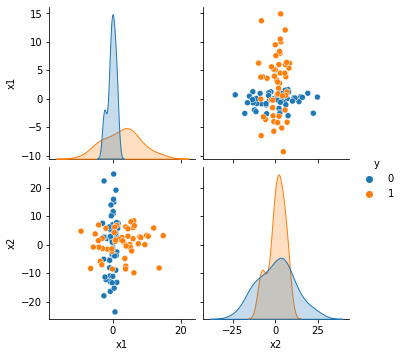

In [4]:
sns.pairplot(vars=["x1","x2"], data=df_s, hue="y")

# Target Dataset

In [5]:
# Generate synthetic dataset for target data
size = 50
c_mean, c_cov = [4,3], [[4,0],[0,16]]
d_mean, d_cov = [2,1], [[9,0],[0,36]]

# size = 50
# c_mean, c_cov = [4,4], [[2,0],[0,2]]
# d_mean, d_cov = [0,1], [[4,0],[0,4]]

# Class 0
c=np.random.default_rng(seed=20).multivariate_normal(c_mean, c_cov, size) 
df3 = pd.DataFrame(c, columns =['x1', 'x2'])
df3['y'] = 0

# Class 1
d=np.random.default_rng(seed=20).multivariate_normal(d_mean, d_cov, size) 
df4 = pd.DataFrame(d, columns =['x1', 'x2'])
df4['y'] = 1

df_t = pd.concat([df3,df4], ignore_index=True, axis=0)
X_t = df_t.iloc[:,:2]
y_t = df_t['y']
df_t

,x1,x2,y
0,6.407350,1.561326,0
1,4.634472,8.587472,0
2,3.020900,4.656537,0
3,2.199279,-0.656483,0
4,5.858410,-0.993725,0
...,...,...,...
95,5.482399,5.063329,1
96,2.861201,15.279804,1
97,2.703117,9.966505,1
98,-4.811930,-6.431870,1


In [6]:
# Calculate mean vector for target dataset
print('Mean Vector for Target data: \n', df_t.iloc[:,:2].mean(), '\n')

# Calculate covariance matrix for target dataset
print('Covariance matrix for Target data: \n')
display(df_t.iloc[:,:2].cov())

Mean Vector for Target data: 
 x1    2.205530
x2    1.661112
dtype: float64 

Covariance matrix for Target data: 



,x1,x2
x1,10.847733,3.045152
x2,3.045152,31.139689


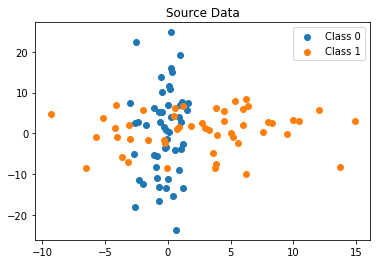

In [7]:
X_s ,y_s = np.asarray(X_s), np.asarray(y_s)
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y_s == class_value)
    # create scatter of these samples
    plt.scatter(X_s[row_ix, 0], X_s[row_ix, 1])
# show the plot
plt.title('Source Data')
plt.legend(['Class 0', 'Class 1'])
plt.show()

Target Covariance matrix is symmetric and positive definite

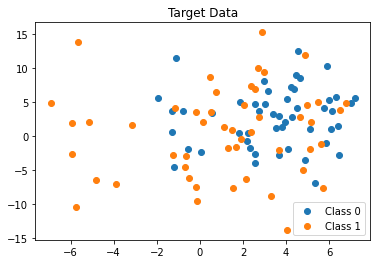

In [8]:
X_t, y_t = np.asarray(X_t), np.asarray(y_t)
# create scatter plot for samples from each class
for class_value in range(2):
    # get row indexes for samples with this class
    row_ix = np.where(y_t == class_value)
    # create scatter of these samples
    plt.scatter(X_t[row_ix, 0], X_t[row_ix, 1])
# show the plot
plt.title('Target Data')
plt.legend(['Class 0', 'Class 1'])
plt.show()

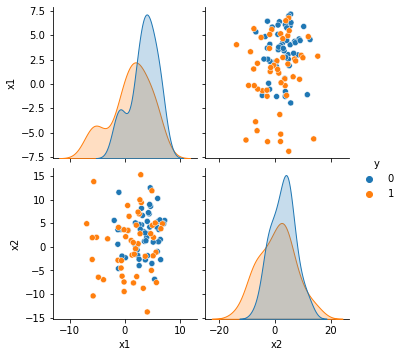

In [9]:
sns.pairplot(vars=["x1","x2"], data=df_t, hue="y")

In [10]:
# Probability of y
p_y = (len(df_s[df_s['y']==0]))/len(df_s)
p_y

0.5

P(y) is same for both source and target

In [11]:
class subspace:
    def __init__(self,clf,S,T,d):
        self.S = S
        self.T = T
        self.d = d
#         print(self.S)
    def pca(self,x, n_components):
        cov = np.cov(x , rowvar = False)
        eigen_values , eigen_vectors = np.linalg.eigh(cov)
#         print('eignevec', eigen_vectors,'\n','eigen_values',eigen_values,'\n')
        sorted_index = np.argsort(eigen_values)[::-1]
        sorted_eigenvalue = eigen_values[sorted_index]
        sorted_eigenvectors = eigen_vectors[:,sorted_index]
        return sorted_eigenvectors[:,0:n_components]
    def fit_predict(self):
        #normalising the data
        scale = StandardScaler()
        x_S = self.S.iloc[:,:2]
        x_T = self.T.iloc[:,:2]
        x_T = scale.fit_transform(x_T)
        x_S = scale.fit_transform(x_S)
        
#         print(x_S)
#         print(x_T)
        
        y_S = self.S.iloc[:,-1]
        y_T = self.T.iloc[:,-1]
#         print(y_S)
#         print(y_T)
        
        #pca and picking the top eigen vectors
        xs = self.pca(x_S,self.d)
        xt = self.pca(x_T,self.d)
        xa = np.dot(np.dot(xs,xs.T),xt)
        sa = np.dot(x_S,xa)
        st = np.dot(x_T,xt)
        fig, ax = plt.subplots()
        
        # create scatter plot for Subspace aligned dataset
        for class_value in range(2):
            # get row indexes for samples with this class
            row_ix = np.where(y_t == class_value)
            # create scatter of these samples
            plt.scatter(sa[row_ix, 0], sa[row_ix, 1])
        # show the plot
        plt.title('Subspace Aligned Data')
        plt.legend(['Class 0', 'Class 1'])
        plt.show()
        
        #GNB
        if clf =='gnb':
            model = GaussianNB()
            model.fit(sa,y_S)
            labels = model.predict(st)

        #KNN
        elif clf == 'knn':
            model=KNeighborsClassifier()
            model.fit(sa,y_S)
            labels = model.predict(st)

        #SGD
        elif clf == 'sgd':
            model = SGDClassifier()
            model.fit(sa,y_S)
            labels = model.predict(st)
            
        #Random Forest
        elif clf == 'rf':
            model = RandomForestClassifier()
            model.fit(sa,y_S)
            labels = model.predict(st)
        
        #SVM
        elif clf == 'svm':
            model = svm.SVC()
            model.fit(sa,y_S)
#             labels = model.predict(sa)
            labels = model.predict(st)
            
        
        #Ridge Classifier
        elif clf == 'ridge':
            model = RidgeClassifier()
            model.fit(sa,y_S)
            labels = model.predict(st)
            
        fig, ax = plt.subplots()
        title = ('Decision surface with SA')
        
        
#         plot_decision_regions(sa, np.asarray(labels),model,legend=2)
        plot_decision_regions(st, np.asarray(labels),model,legend=2)
        

        ax.set_ylabel('y label')
        ax.set_xlabel('x label')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        plt.show()
        
        return accuracy_score(labels,y_T)
    


In [12]:
def classifier(clf,S,T):
    
    x_S = S.iloc[:,:2]
    x_T = S.iloc[:,:2]
    y_S = S.iloc[:,-1]
    y_T = T.iloc[:,-1]
    scale = StandardScaler()
    x_S = scale.fit_transform(x_S)
    x_T = scale.fit_transform(x_T)
    
    #GNB
    if clf =='gnb':
        model = GaussianNB()
        model.fit(x_S,y_S)
        labels = model.predict(x_T)

    #KNN
    elif clf == 'knn':
        model=KNeighborsClassifier()
        model.fit(x_S,y_S)
        labels = model.predict(x_T)
    
    #SGD
    elif clf == 'sgd':
        model = SGDClassifier()
        model.fit(x_S,y_S)
        labels = model.predict(x_T)
    
    #Random Forest
    elif clf == 'rf':
        model = RandomForestClassifier()
        model.fit(x_S,y_S)
        labels = model.predict(x_T)
        
    #SVM
    elif clf == 'svm':
        model = svm.SVC()
        model.fit(x_S,y_S)
#         labels = model.predict(x_S)
        labels = model.predict(x_T)
        
        
    #Ridge Classifier
    elif clf == 'ridge':
        model = RidgeClassifier()
        model.fit(x_S,y_S)
        labels = model.predict(x_T)
        
        
    
    fig, ax = plt.subplots()
    title = ('Decision surface without SA')
#     plot_decision_regions(x_S, np.asarray(labels),clf=model,legend=2)
    plot_decision_regions(x_T, np.asarray(labels),model,legend=2)
    
    ax.set_ylabel('y label')
    ax.set_xlabel('x label')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()
    
    
    
    return accuracy_score(labels,y_T)

Plots for decision boundaries and regions on source and target after subspace alignment

Test with Linear base and quadratic base 

Try 2-3 with different mean and covariances

In [13]:
data_list = [df_s,df_t]
data_iter = list(permutations(data_list,2))
# data_iter

Enter the type of classifier: svm
dist1 -> dist2


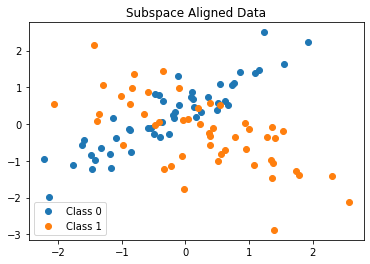

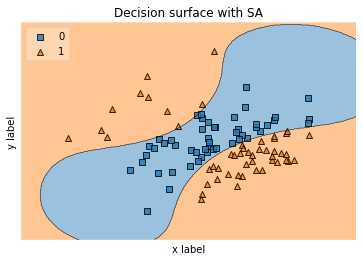

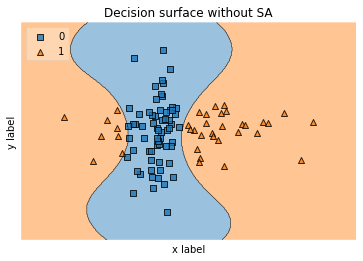

dist2 -> dist1


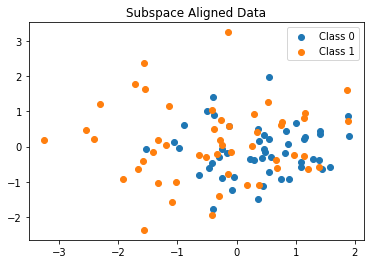

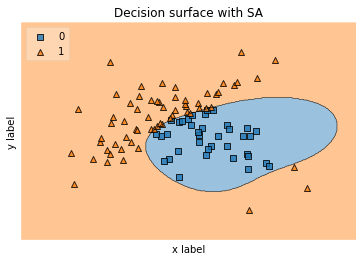

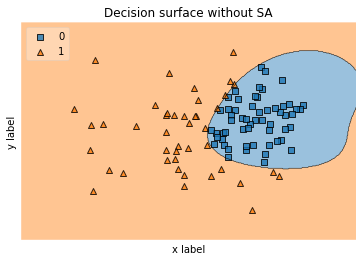

Accuracy: 


,subspace,without subspace
"(dist1, dist2)",40.0,86.0
"(dist2, dist1)",29.0,71.0


Time elapsed: 


,subspace,without subspace
"(dist1, dist2)",0.784334,0.660379
"(dist2, dist1)",0.948789,0.872042


In [14]:
# types of clf: sgd, knn, gnb, rf, svm, ridge
clf = input('Enter the type of classifier: ')

list1 = ["dist1","dist2"]
index = list(permutations(list1,2))
# print(index)
methods = ["subspace","without subspace"]
data_timedf = pd.DataFrame(index=index,columns=methods)
data_accdf = pd.DataFrame(index=index,columns=methods)

for i in range(len(index)):
    print(index[i][0],'->',index[i][1])
    t0 = time()
    sub = subspace(clf,data_iter[i][0],data_iter[i][1],2)
    data_accdf.iloc[i,0] = (sub.fit_predict()*100)
    t1 = time()
    data_timedf.iloc[i,0] = t1-t0
    t2 = time()
    data_accdf.iloc[i,1] = classifier(clf,data_iter[i][0],data_iter[i][1])*100
    t3 = time()
    data_timedf.iloc[i,1] = t3-t2
    
print('Accuracy: ')
display(data_accdf)
print('Time elapsed: ')
display(data_timedf)

1. Check the diff classifier an check accuracies
2. knn, rf try optimizing params
3. decision boundary on source and target showing original labels as well
4. Check the row clolumn notation while applying sa whether to take transpose or not
5. Email the subspace source code link
6. increase the number of features and then perform pca
7. Check with non diagonal cov matrix
